In [0]:
google_colab = eval(input("Running on Google Colab? Please type True or False"))
                    
if google_colab:

    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials


    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)


    helper_link = '1-L6-qALyk6Oz5lTpYLHeNEq9V0iF_D-v'
    helper_FILE ='helper.py'


    mat_to_csv_link='1hOAbTigsGIjhduolzhB5IFMdXOwITOW3'
    mat_to_csv_file='mat_to_csv.py'


    preprocessing_link='1Hl31_f2fmw3UJHcmOtiSv4MlTpkvdBsc'
    preprocessing_file='preprocessing.py'


    train_link='1055HVhKm-5OvV2Rb8sRxTCd_PLxVnzKq'
    train_file='HAR_train.csv'

    test_link='1itRqhHN5yqgMlhKqqKQxUs3ntE6euhjp'
    test_file='HAR_test.csv'

    helper= drive.CreateFile({'id': helper_link})
    helper.GetContentFile(helper_FILE)

    mat_to_csv= drive.CreateFile({'id': mat_to_csv_link})
    mat_to_csv.GetContentFile(mat_to_csv_file)

    preprocessing= drive.CreateFile({'id': preprocessing_link})
    preprocessing.GetContentFile(preprocessing_file)


    train = drive.CreateFile({'id': train_link})
    train.GetContentFile(train_file)

    test = drive.CreateFile({'id': test_link})
    test.GetContentFile(test_file)
    
    
    import helper,mat_to_csv,preprocessing
    path = ''

else:
    import os
    base_dir = '/'.join(os.getcwd().split('/')[:-2])
    data_dir = 'data/asg_two'
    path = os.path.join(base_dir,data_dir)
    
    import helpers, mat_to_csv, preprocessing
    

Running on Google Colab? Please type True or FalseTrue


In [0]:
from scipy.io import savemat

In [0]:
import pandas as pd
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
import seaborn as sns
import numpy as np


from numpy import fft

from scipy import signal
from scipy.fftpack import rfft, fftfreq

# color palette
colors =['#DAF7A6','#05C157','#FFC300','#FF5733','#900C3F','#581845',
        '#1d01ef','#b883ff','#6e40ad','#000611','#b7b9be',
        '#DAF7A6','#05C157','#FFC300','#FF5733','#900C3F','#581845',
         '#1d01ef','#b883ff','#6e40ad','#000611','#b7b9be']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train=pd.read_csv(os.path.join(path,'HAR_train.csv'))
test=pd.read_csv(os.path.join(path,'HAR_test.csv'))


In [0]:
COLNAMES_TRAIN = ['acc_z', 'acc_xy', 'gyro_x','gyro_y','gyro_z','label','id']
COLNAMES_TEST = ['acc_z', 'acc_xy', 'gyro_x','gyro_y','gyro_z','id']

In [0]:
activities = {
    1: "Running",
    2: "Walking",
    3: "Standing",
    4: "Sitting",
    5: "Lying"}


The data is collected from 8 subjects with the 16Hz sampling rate (16 values per second). During the retrieval, the subjects performed five types of activities: running, walking, standing, sitting and lying. The obtained measurements are the acceleration and gyro in the x,y and z axis. There has been a previous preprocessing where acceleration in the x and y axes have been merged as well as techniques for cleaning the signal.






## Exploring raw data - What does signal data look like?- Is there a difference between the features for each activity- What activities where performed and how often?- What does the data look like in the frequency domain?

Exploring raw data
What does signal data look like?
Is there a difference between the features for each activity


In [0]:
## what does the signal data look like
idx = 0
data_0 = train[train['id'] == idx]

__What does the signal data look like?__


In [0]:
def paint_each_col():
    fig, axes= plt.subplots(3, 2, sharex=False, sharey=False)
    fig.set_size_inches(18.5, 10.5)
    counter = 0
    x_values = np.arange(len(data_0))
    for i in range(3):
        for j in range(2):
            axes[i][j].plot(
                x_values, data_0[data_0.columns[counter]],
                color = colors[counter]
            )
            axes[i][j].set_title(data_0.columns[counter])
            if counter == 5:
                axes[i][j].set_yticklabels(labels=activities.values())
                axes[i][j].set_yticks(ticks=np.arange(1,6))
            counter += 1
    plt.show()
    plt.close()
        

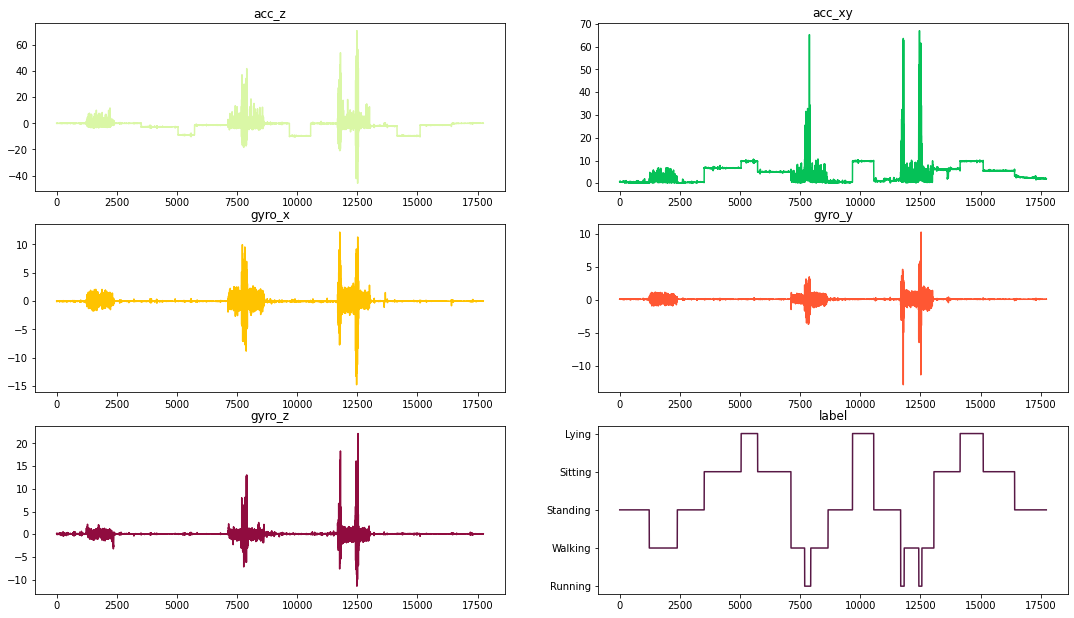

In [0]:
paint_each_col()

The acceleration in the xy plane and z axis represents the translational motion while the axes gyro_x, gyro_y and gyro_z make refference to the rotational motion. Regarding data corresponding to the lying label around timepoint 15000, these three axes lie in different ranges and are easier to understand, gyro_z or yaw, is the axis perpendicular to the transverse plane of the subject and it has the widest range of rotation in the graph in the smallest amount of time (it is the easiest body-rotation when we are lied down). The other two axes are not easy to identify from the graph, but x-axis represents movement in the coronal plane of the subject (roll) whereas the gyro_y or pitch would show movement in the sagittal plane.


As expected, there is a higher amplitude in the signal for activities such as running and walking compared to sitting, standing or lying. 

__Can differencen be seen in the signal for eacht activity?__

In [0]:
def paint_each_col_by_label():
    fig, axes= plt.subplots(3, 2, sharex=False, sharey=False)
    fig.set_size_inches(18.5, 10.5)
    counter = 0
    x_values = np.arange(len(data_0))
    for i in range(3):
        for j in range(2):
            axes[i][j].scatter(
                x_values, data_0[data_0.columns[counter]],
                c = data_0['label'], 
                label= data_0['label']
            )
            axes[i][j].set_title(data_0.columns[counter])
            if counter == 5:
                axes[i][j].set_yticklabels(labels=activities.values())
                axes[i][j].set_yticks(ticks=np.arange(1,6))
            counter += 1
    plt.show()
    plt.close()
        

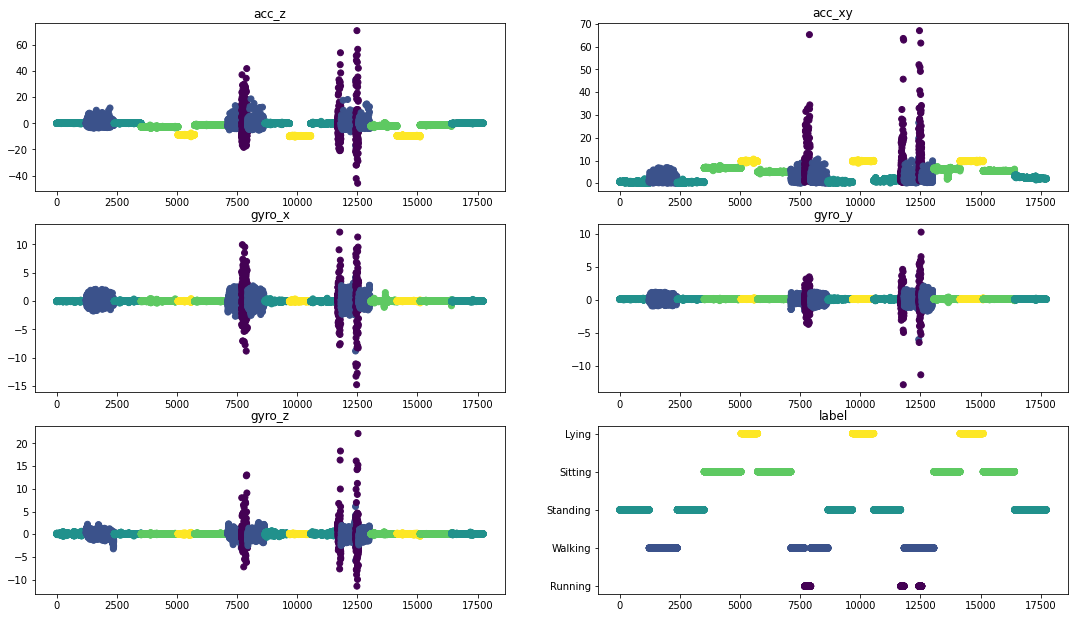

In [0]:
paint_each_col_by_label()

__What does the activity profile look like for each user?__

In [0]:
def count_activities():
    activity_profiles = []
    for idx in set(train['id']):
        temp = {}
        for label in train[train['id'] == idx]['label']:
            temp[str(int(label))] = temp.get(str(int(label)),0)+1
        activity_profiles.append(temp)
    return activity_profiles

In [0]:
activity_profiles = count_activities()

In [0]:
def get_activity_dist(activity_profiles=activity_profiles):
    return [
        [profile[str(index)] for profile in activity_profiles]
        for index in range(1,6)]


In [0]:
activity_distribution = get_activity_dist()


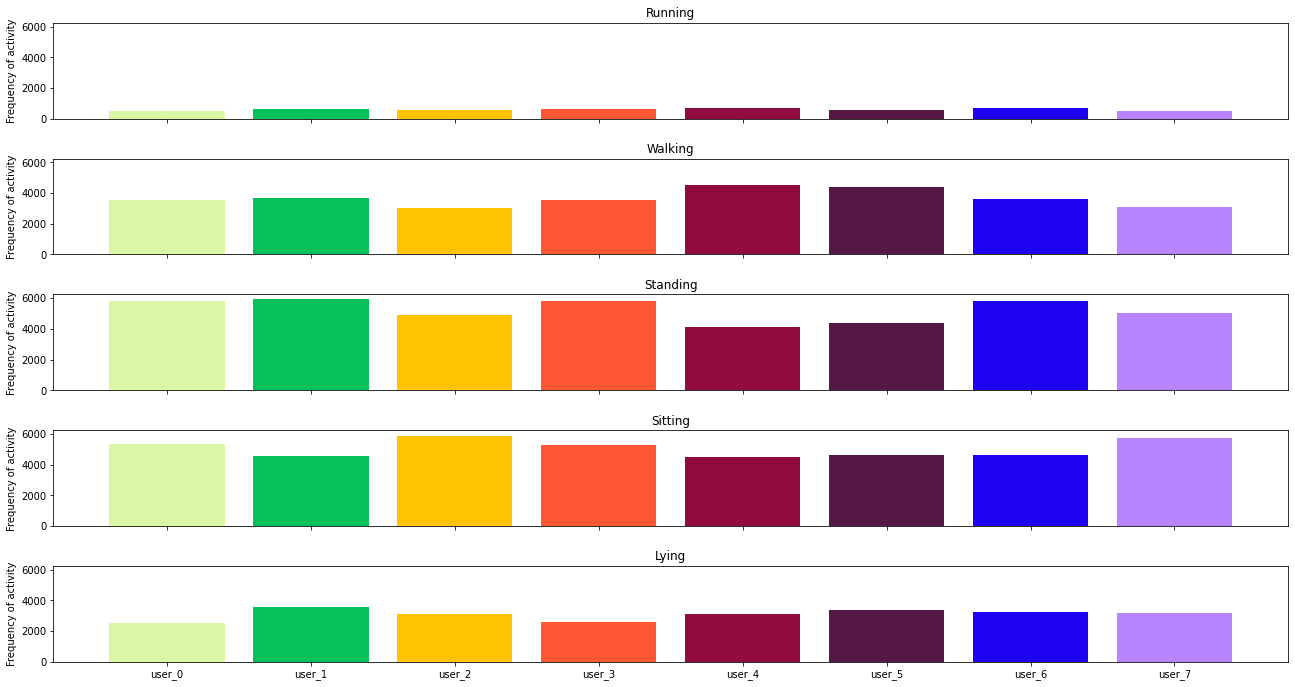

In [0]:
def paint_activity_profiles():
    fig, axes= plt.subplots(5,1, sharex=True, sharey=True)
    fig.set_size_inches(18.5, 10)
    fig. tight_layout(pad=3.0)
    counter = 0
    labels = activities.values()
    idxes = [_ for _ in range(8)]
    for i in range(5):
            axes[i].bar(
                idxes,
                activity_distribution[i],
                color=colors[:8]
            )
            axes[i].set_xticklabels([f'user_{idx}' for idx in idxes])
            axes[i].set_xticks(idxes)
            axes[i].set_title(activities[i+1])
            axes[i].set_ylabel('Frequency of activity')
    plt.show()
    plt.close()
paint_activity_profiles()

As running is the least frequent activity performed by the users, the model could be less accurate predicting that label if the amount of data was not enough. 

__What does the data look like in the frequency domain?__

In [0]:
def fourier_transform(data):
    data_copy = deepcopy(data)
    for col in data_copy.columns[:-2]:
        temp_results = []
        for idx in range(0,8):
            
            temp_ft = abs(fft.fft(data_copy[data_copy['id']==idx][col])/
                          len(data_copy[data_copy['id']==idx][col]))
            temp_results.extend(temp_ft)
        data_copy[f'{col}_ft'] = temp_results
    return data_copy

In [0]:
def paint_each_col(data):
    fig, axes = plt.subplots(5, 1, sharex=False, sharey=False)
    data_0 = data[data['id'] == 0]
    fig.set_size_inches(10, 10.5)
    counter = 0
    columns_to_plot = [col for col in data_0.columns if 'ft' in col]
    frequencies = fftfreq(len(data_0))
    mask = frequencies>0
    for i in range(5):
        axes[i].plot(
            frequencies[mask], data_0[columns_to_plot[counter]][mask],
            color = colors[counter]
            )
        axes[i].set_title(columns_to_plot[counter])
        counter += 1
    plt.show()
    plt.close()
        

In [0]:
data_trans = fourier_transform(train)

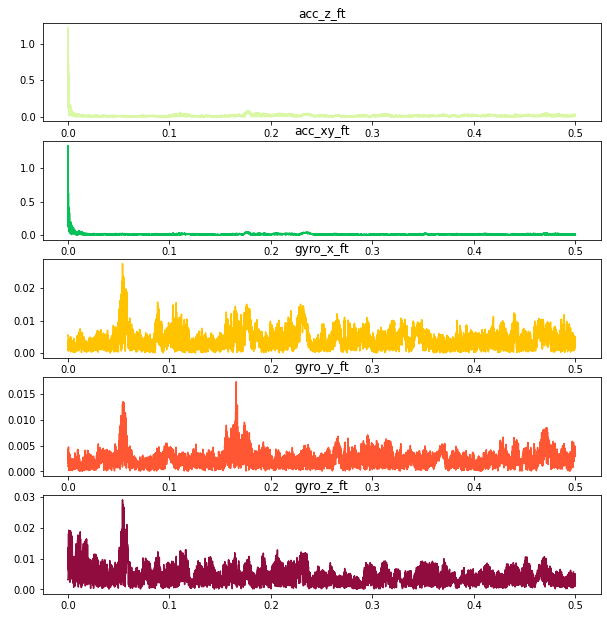

In [0]:
paint_each_col(data_trans)

# Segmentation and feature extraction

Fixed sized segments are created from the raw signal. The window size used is 16, which equals to 1 second of data, as well as the step size, as there is no overlap.

The label (activity) for each segment is selected by the most frequent class label presented in that window.


Time-Domain features:

- Mean value of signal segment
- Variance of signal segment
- Standard deviation of signal segment
- Mean absolute deviation
- Median value of signal segment
- Minimum value of signal segment
- Maximum amplitude of signal segment

Frequency-Domain Features:
- Power spectral entropy
- Discrete FFT Coef.


In [0]:
train.head()
df = deepcopy(train)
df = preprocessing.segmentation(df)



/content/preprocessing.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['window_id'][start:end] = counter


In [0]:
n_windows = len(set(df['window_id']))

In [0]:
results_pse=[]
for column in train.columns[:-2]:
  results_pse.append(preprocessing.apply_to_window(df,n_windows,column,preprocessing.power_spectral_entropy))

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 16, using nperseg = 16
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 34, using nperseg = 34
  .format(nperseg, input_length))


In [0]:
for index,column in enumerate(train.columns[:-2]):
  df=preprocessing.map_back_to_window(df,results_pse[index],f'{column}_pse')

In [0]:
results_fourier=[]
for column in train.columns:
  results_fourier.append(preprocessing.apply_to_window(df,n_windows,column,preprocessing.select_top_fourier))




In [0]:
for index,column in enumerate(train.columns[:-2]):
  df=preprocessing.map_back_more_windows(df, results_fourier[index], [f'{column}_{num}_ft' for num in range(3)], column_key='window_id')

In [0]:
  data=preprocessing.add_features(df)

In [0]:
data.head()

,acc_z,acc_xy,gyro_x,gyro_y,gyro_z,label,id,window_id,acc_z_pse,acc_xy_pse,gyro_x_pse,gyro_y_pse,gyro_z_pse,acc_z_0_ft,acc_z_1_ft,acc_z_2_ft,acc_xy_0_ft,acc_xy_1_ft,acc_xy_2_ft,gyro_x_0_ft,gyro_x_1_ft,gyro_x_2_ft,gyro_y_0_ft,gyro_y_1_ft,gyro_y_2_ft,gyro_z_0_ft,gyro_z_1_ft,gyro_z_2_ft,freq_label,mean_acc_z,std_acc_z,mad_acc_z,min_acc_z,max_acc_z,var_acc_z,median_acc_z,mean_acc_xy,std_acc_xy,mad_acc_xy,min_acc_xy,max_acc_xy,var_acc_xy,median_acc_xy,mean_gyro_x,std_gyro_x,mad_gyro_x,min_gyro_x,max_gyro_x,var_gyro_x,median_gyro_x,mean_gyro_y,std_gyro_y,mad_gyro_y,min_gyro_y,max_gyro_y,var_gyro_y,median_gyro_y,mean_gyro_z,std_gyro_z,mad_gyro_z,min_gyro_z,max_gyro_z,var_gyro_z,median_gyro_z
0,0.024173,0.594417,-0.022736,0.111962,0.060499,3.0,0.0,0.0,1.732351,1.170034,1.180243,1.616855,1.187501,0.067305,0.021336,0.015836,1.360139,0.104352,0.051294,0.065817,0.03308,0.023311,0.211595,0.0056,0.00541,0.169585,0.070009,0.067989,3,0.033653,0.025622,0.024632,-0.025136,0.086072,0.000657,0.035892,0.680069,0.092101,0.08427,0.525821,0.869506,0.008483,0.653574,-0.032908,0.031374,0.015267,-0.105143,0.008289,0.000984,-0.024789,0.105798,0.006749,0.006893,0.095647,0.122891,0.000046,0.104087,0.084793,0.074651,0.026703,-0.064442,0.220029,0.005573,0.068779
1,0.019905,0.602472,-0.012875,0.103796,0.055157,3.0,0.0,0.0,1.732351,1.170034,1.180243,1.616855,1.187501,0.067305,0.021336,0.015836,1.360139,0.104352,0.051294,0.065817,0.03308,0.023311,0.211595,0.0056,0.00541,0.169585,0.070009,0.067989,3,0.033653,0.025622,0.024632,-0.025136,0.086072,0.000657,0.035892,0.680069,0.092101,0.08427,0.525821,0.869506,0.008483,0.653574,-0.032908,0.031374,0.015267,-0.105143,0.008289,0.000984,-0.024789,0.105798,0.006749,0.006893,0.095647,0.122891,0.000046,0.104087,0.084793,0.074651,0.026703,-0.064442,0.220029,0.005573,0.068779
2,0.034749,0.525821,-0.020016,0.103193,0.057541,3.0,0.0,0.0,1.732351,1.170034,1.180243,1.616855,1.187501,0.067305,0.021336,0.015836,1.360139,0.104352,0.051294,0.065817,0.03308,0.023311,0.211595,0.0056,0.00541,0.169585,0.070009,0.067989,3,0.033653,0.025622,0.024632,-0.025136,0.086072,0.000657,0.035892,0.680069,0.092101,0.08427,0.525821,0.869506,0.008483,0.653574,-0.032908,0.031374,0.015267,-0.105143,0.008289,0.000984,-0.024789,0.105798,0.006749,0.006893,0.095647,0.122891,0.000046,0.104087,0.084793,0.074651,0.026703,-0.064442,0.220029,0.005573,0.068779
3,0.059832,0.621057,-0.026841,0.104378,0.063853,3.0,0.0,0.0,1.732351,1.170034,1.180243,1.616855,1.187501,0.067305,0.021336,0.015836,1.360139,0.104352,0.051294,0.065817,0.03308,0.023311,0.211595,0.0056,0.00541,0.169585,0.070009,0.067989,3,0.033653,0.025622,0.024632,-0.025136,0.086072,0.000657,0.035892,0.680069,0.092101,0.08427,0.525821,0.869506,0.008483,0.653574,-0.032908,0.031374,0.015267,-0.105143,0.008289,0.000984,-0.024789,0.105798,0.006749,0.006893,0.095647,0.122891,0.000046,0.104087,0.084793,0.074651,0.026703,-0.064442,0.220029,0.005573,0.068779
4,0.044743,0.653001,-0.014540,0.103560,0.066084,3.0,0.0,0.0,1.732351,1.170034,1.180243,1.616855,1.187501,0.067305,0.021336,0.015836,1.360139,0.104352,0.051294,0.065817,0.03308,0.023311,0.211595,0.0056,0.00541,0.169585,0.070009,0.067989,3,0.033653,0.025622,0.024632,-0.025136,0.086072,0.000657,0.035892,0.680069,0.092101,0.08427,0.525821,0.869506,0.008483,0.653574,-0.032908,0.031374,0.015267,-0.105143,0.008289,0.000984,-0.024789,0.105798,0.006749,0.006893,0.095647,0.122891,0.000046,0.104087,0.084793,0.074651,0.026703,-0.064442,0.220029,0.005573,0.068779


## Preprocessing the test data set


In [0]:
test_df = deepcopy(test)
test_df = preprocessing.segmentation(test_df)
n_windows = len(set(test_df['window_id']))

/content/preprocessing.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['window_id'][start:end] = counter


In [0]:
results_pse=[]
for column in test.columns[:-1]:
  results_pse.append(preprocessing.apply_to_window(test_df,n_windows,column,preprocessing.power_spectral_entropy))

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 16, using nperseg = 16
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 44, using nperseg = 44
  .format(nperseg, input_length))


In [0]:
for index,column in enumerate(test.columns[:-1]):
  test_df=preprocessing.map_back_to_window(test_df,results_pse[index],f'{column}_pse')

In [0]:

results_fourier=[]
for column in test.columns:
  results_fourier.append(preprocessing.apply_to_window(test_df,n_windows,column,preprocessing.select_top_fourier))


In [0]:
for index,column in enumerate(train.columns[:-2]):
  test_df=preprocessing.map_back_more_windows(test_df, results_fourier[index], [f'{column}_{num}_ft' for num in range(3)], column_key='window_id')

In [0]:
data_test=preprocessing.add_features_test(test_df)

In [0]:
data_test.head()

,acc_z,acc_xy,gyro_x,gyro_y,gyro_z,id,window_id,acc_z_pse,acc_xy_pse,gyro_x_pse,gyro_y_pse,gyro_z_pse,acc_z_0_ft,acc_z_1_ft,acc_z_2_ft,acc_xy_0_ft,acc_xy_1_ft,acc_xy_2_ft,gyro_x_0_ft,gyro_x_1_ft,gyro_x_2_ft,gyro_y_0_ft,gyro_y_1_ft,gyro_y_2_ft,gyro_z_0_ft,gyro_z_1_ft,gyro_z_2_ft,mean_acc_z,std_acc_z,mad_acc_z,min_acc_z,max_acc_z,var_acc_z,median_acc_z,mean_acc_xy,std_acc_xy,mad_acc_xy,min_acc_xy,max_acc_xy,var_acc_xy,median_acc_xy,mean_gyro_x,std_gyro_x,mad_gyro_x,min_gyro_x,max_gyro_x,var_gyro_x,median_gyro_x,mean_gyro_y,std_gyro_y,mad_gyro_y,min_gyro_y,max_gyro_y,var_gyro_y,median_gyro_y,mean_gyro_z,std_gyro_z,mad_gyro_z,min_gyro_z,max_gyro_z,var_gyro_z,median_gyro_z
0,-0.065170,0.382690,-0.213375,0.189977,0.132347,0.0,0.0,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.17433,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.02536,0.028803,0.048592,0.052839,-0.06517,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.02595,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.12176
1,0.018816,0.564156,0.059815,0.091269,0.129378,0.0,0.0,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.17433,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.02536,0.028803,0.048592,0.052839,-0.06517,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.02595,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.12176
2,0.028664,0.534412,0.109575,0.062156,0.158687,0.0,0.0,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.17433,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.02536,0.028803,0.048592,0.052839,-0.06517,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.02595,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.12176
3,0.044055,0.531722,0.077823,0.070266,0.213016,0.0,0.0,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.17433,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.02536,0.028803,0.048592,0.052839,-0.06517,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.02595,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.12176
4,0.073239,0.330309,0.042073,0.104790,0.254729,0.0,0.0,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.17433,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.02536,0.028803,0.048592,0.052839,-0.06517,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.02595,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.12176


In [0]:
if google_colab:
    from google.colab import drive
    drive.mount("/content/drive/")

    path='drive/My Drive'
else: 
  path=''
# data.to_csv(os.path.join(path,'HAR_train_ext.csv'), index = False)
# data_test.to_csv(os.path.join(path,'HAR_test_exxt.csv'), index = False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
data.to_csv(os.path.join(path,'HAR_train_ext.csv'), index = False)
data_test.to_csv(os.path.join(path,'HAR_test_ext.csv'), index = False)

## Modelling the activity - base model with original features

In [0]:
base_train=pd.read_csv('HAR_train.csv')
base_test=pd.read_csv('HAR_test.csv')


In [0]:
target = base_train['label']
base_train.drop(axis=1, labels=['label'], inplace=True)

In [0]:
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# nonlinear models
	models['random forest'] = RandomForestClassifier()
	models['decision tree'] = DecisionTreeClassifier()
	return models
 
# evaluate a single model
def evaluate_model(trainX, trainy, testX, testy, model):
				# fit the model
				model.fit(trainX, trainy)
				# make predictions
				yhat = model.predict(testX)
				# evaluate predictions
				accuracy = accuracy_score(testy, yhat)
				show_confusion_matrix(testy, yhat)
				print(classification_report(testy, yhat))
	    	
				return accuracy * 100.0
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(trainX, trainy, testX, testy, models):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		results[name] = evaluate_model(trainX, trainy, testX, testy, model)
		# show process
		print('Accuracy-> %s: %.3f' % (name, results[name]))
	return results

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=list(activities.values()),
                yticklabels=list(activities.values()),
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


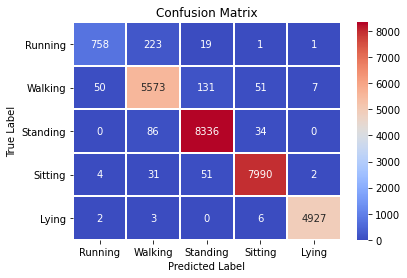

              precision    recall  f1-score   support

         1.0       0.93      0.76      0.83      1002
         2.0       0.94      0.96      0.95      5812
         3.0       0.98      0.99      0.98      8456
         4.0       0.99      0.99      0.99      8078
         5.0       1.00      1.00      1.00      4938

    accuracy                           0.98     28286
   macro avg       0.97      0.94      0.95     28286
weighted avg       0.98      0.98      0.97     28286

Accuracy-> random forest: 97.518


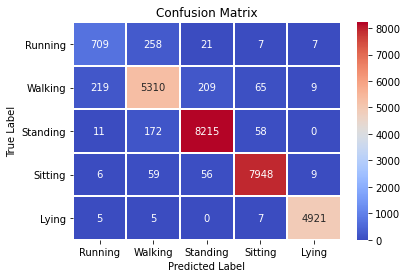

              precision    recall  f1-score   support

         1.0       0.75      0.71      0.73      1002
         2.0       0.91      0.91      0.91      5812
         3.0       0.97      0.97      0.97      8456
         4.0       0.98      0.98      0.98      8078
         5.0       0.99      1.00      1.00      4938

    accuracy                           0.96     28286
   macro avg       0.92      0.91      0.92     28286
weighted avg       0.96      0.96      0.96     28286

Accuracy-> decision tree: 95.818


In [0]:
models = define_models()
X_train, X_val, y_train, y_val = train_test_split(base_train, target, test_size=0.2, random_state=42)
# evaluate models
results = evaluate_models(X_train, y_train, X_val, y_val, models)

## Modelling the activity - with engineered features


In [0]:
ext_train=pd.read_csv(os.path.join(path,'HAR_train_ext.csv'))
ext_test=pd.read_csv(os.path.join(path,'HAR_test_ext.csv'))


In [0]:
train_features=ext_train.drop_duplicates(subset='window_id', keep="first").reset_index(drop=True)
test_features=ext_test.drop_duplicates(subset='window_id', keep="first").reset_index(drop=True)

In [0]:
target = train_features['label']
train_features.drop(axis=1, labels=['label','freq_label','id','window_id'], inplace=True)

In [0]:
test_features.drop(axis=1, labels=['id','window_id'], inplace=True)

In [0]:
test_features.head()

,acc_z,acc_xy,gyro_x,gyro_y,gyro_z,acc_z_pse,acc_xy_pse,gyro_x_pse,gyro_y_pse,gyro_z_pse,acc_z_0_ft,acc_z_1_ft,acc_z_2_ft,acc_xy_0_ft,acc_xy_1_ft,acc_xy_2_ft,gyro_x_0_ft,gyro_x_1_ft,gyro_x_2_ft,gyro_y_0_ft,gyro_y_1_ft,gyro_y_2_ft,gyro_z_0_ft,gyro_z_1_ft,gyro_z_2_ft,mean_acc_z,std_acc_z,mad_acc_z,min_acc_z,max_acc_z,var_acc_z,median_acc_z,mean_acc_xy,std_acc_xy,mad_acc_xy,min_acc_xy,max_acc_xy,var_acc_xy,median_acc_xy,mean_gyro_x,std_gyro_x,mad_gyro_x,min_gyro_x,max_gyro_x,var_gyro_x,median_gyro_x,mean_gyro_y,std_gyro_y,mad_gyro_y,min_gyro_y,max_gyro_y,var_gyro_y,median_gyro_y,mean_gyro_z,std_gyro_z,mad_gyro_z,min_gyro_z,max_gyro_z,var_gyro_z,median_gyro_z
0,-0.065170,0.382690,-0.213375,0.189977,0.132347,1.589162,1.032474,1.895123,1.942443,0.621458,0.057606,0.042066,0.035321,0.564926,0.174330,0.098035,0.057237,0.056531,0.040495,0.202452,0.018148,0.016291,0.272671,0.084898,0.025360,0.028803,0.048592,0.052839,-0.065170,0.103487,0.002361,0.022307,0.282463,0.150687,0.141287,0.092421,0.564156,0.022707,0.229528,0.028618,0.070521,0.041575,-0.213375,0.109575,0.004973,0.046741,0.101226,0.025950,0.007866,0.062156,0.189977,0.000673,0.099662,0.136336,0.064986,0.064462,0.051958,0.254729,0.004223,0.121760
1,0.078223,0.212994,-0.001144,0.111262,0.048262,1.545879,1.326191,1.568689,1.648105,1.375358,0.050934,0.045998,0.035858,0.666028,0.074475,0.040038,0.006617,0.003878,0.003582,0.214668,0.004642,0.002786,0.121328,0.009990,0.009105,0.022999,0.052915,0.060811,-0.063575,0.114105,0.002800,0.014980,0.333014,0.068500,0.104150,0.212994,0.447408,0.004692,0.322179,0.001791,0.006790,0.008178,-0.010981,0.014935,0.000046,0.000358,0.107334,0.004913,0.005440,0.099738,0.118541,0.000024,0.106316,0.060664,0.011540,0.009820,0.040583,0.085414,0.000133,0.058226
2,0.047789,0.483903,0.015362,0.089276,0.076102,1.615106,1.497312,1.662061,1.547607,0.566653,0.046018,0.034616,0.028826,0.866682,0.034015,0.023825,0.035283,0.006890,0.005060,0.201826,0.007810,0.007608,0.153275,0.042917,0.010147,0.023009,0.040194,0.033931,-0.027401,0.146202,0.001616,0.026536,0.433341,0.034829,0.032660,0.367486,0.483903,0.001213,0.438445,0.017642,0.008129,0.007373,0.003468,0.039978,0.000066,0.016827,0.100913,0.009327,0.010834,0.082763,0.115578,0.000087,0.104557,0.076637,0.032487,0.036943,0.010369,0.117182,0.001055,0.079896
3,-0.010176,0.431925,0.020243,0.101236,0.110254,1.835012,1.896721,1.672197,1.494082,1.208796,0.040301,0.020801,0.020372,0.873844,0.029281,0.024313,0.049722,0.016192,0.013014,0.206063,0.006660,0.003710,0.200321,0.022628,0.008035,0.020150,0.030390,0.027664,-0.058748,0.067642,0.000924,0.022910,0.436922,0.039780,0.040205,0.384994,0.522249,0.001582,0.432439,0.024861,0.018749,0.013739,-0.032397,0.050388,0.000352,0.027353,0.103031,0.006541,0.005821,0.090238,0.116924,0.000043,0.103676,0.100161,0.019319,0.022295,0.062726,0.122655,0.000373,0.107060
4,0.053380,0.445569,0.019008,0.105937,0.136813,1.884278,1.553665,1.756225,1.627057,0.816010,0.067829,0.030454,0.020659,0.737585,0.055700,0.028045,0.048993,0.008702,0.008503,0.202808,0.007771,0.004117,0.197199,0.086296,0.037916,0.033914,0.038290,0.035003,-0.008335,0.126315,0.001466,0.025910,0.368793,0.054652,0.064528,0.293620,0.460609,0.002987,0.353025,0.024496,0.012230,0.010191,0.001826,0.046585,0.000150,0.026002,0.101404,0.008012,0.007356,0.086100,0.115675,0.000064,0.102535,0.098600,0.069504,0.086518,0.015909,0.219892,0.004831,0.087652


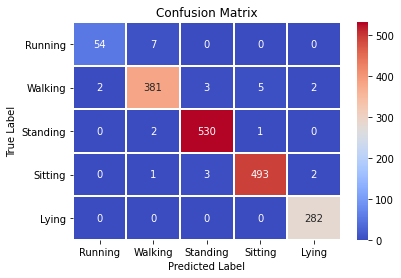

              precision    recall  f1-score   support

         1.0       0.96      0.89      0.92        61
         2.0       0.97      0.97      0.97       393
         3.0       0.99      0.99      0.99       533
         4.0       0.99      0.99      0.99       499
         5.0       0.99      1.00      0.99       282

    accuracy                           0.98      1768
   macro avg       0.98      0.97      0.97      1768
weighted avg       0.98      0.98      0.98      1768

Accuracy-> random forest: 98.416


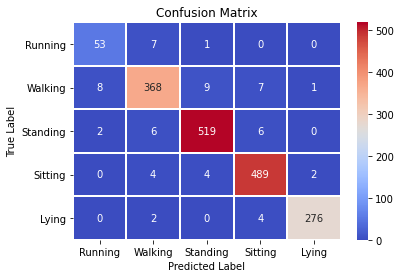

              precision    recall  f1-score   support

         1.0       0.84      0.87      0.85        61
         2.0       0.95      0.94      0.94       393
         3.0       0.97      0.97      0.97       533
         4.0       0.97      0.98      0.97       499
         5.0       0.99      0.98      0.98       282

    accuracy                           0.96      1768
   macro avg       0.94      0.95      0.95      1768
weighted avg       0.96      0.96      0.96      1768

Accuracy-> decision tree: 96.437


In [0]:
models = define_models()
X_train, X_val, y_train, y_val = train_test_split(train_features, target, test_size=0.2, random_state=42)
# evaluate models
results = evaluate_models(X_train, y_train, X_val, y_val, models)

The random forest model shows a better performance than the decision tree model. Standing, sitting and lying get the best results but running and walking still get high scores. The distinction between running and lying or sitting is really good as the number of false positives and false negatives is 0.




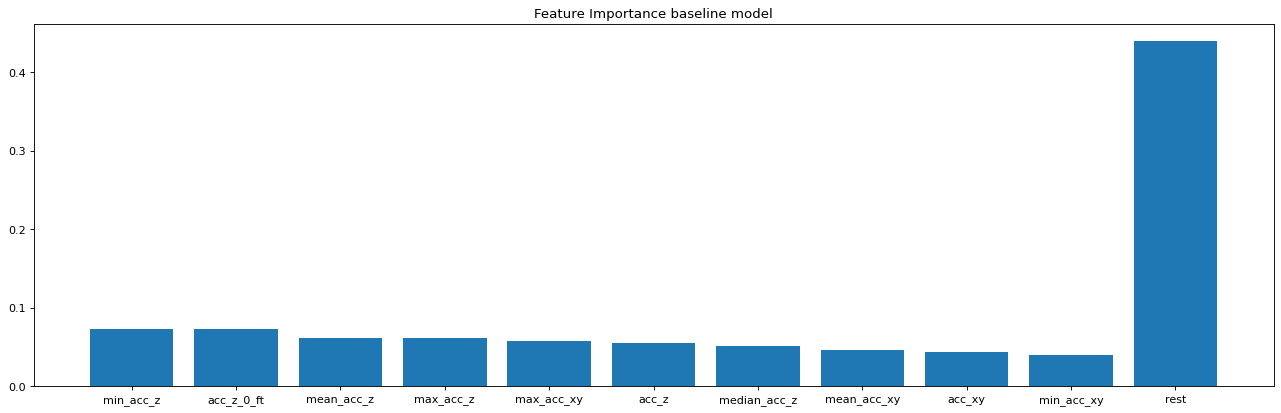

In [0]:
feature_imporance = models['random forest'].feature_importances_
features = train_features.columns
feature_n_importance = sorted(list(zip(feature_imporance,features)),reverse=True)
top_features = feature_n_importance[:10]
all_other_features = (1-sum([tup[0] for tup in top_features]), 'rest')
top_features.append(all_other_features)


plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(
    [tup[1] for tup in top_features],
    [tup[0] for tup in top_features]
)
plt.title('Feature Importance baseline model')
plt.show()
plt.close()

From the graph above it can be concluded that the most informative variable is the acceleration in the z axis, and from the features extracted, the time-domain features are more important than the frequency-domain features.

In [0]:
def test_model(testX, model):
				# fit the model
			
				# make predictions
				yhat = model.predict(testX)
				# evaluate predictions
			
	    	
				return yhat

In [0]:
prediction=test_model(test_features, models['random forest'] )

In [0]:
for i in range(len(prediction)):

    ext_test.loc[ext_test['window_id']==i, 'predicted_label'] = prediction[i] 

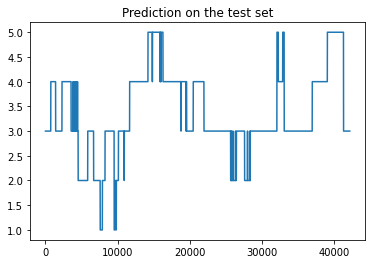

In [0]:
plt.plot(ext_test['predicted_label'])
plt.title('Prediction on the test set')
plt.show()
plt.close()


In [0]:
savemat(os.path.join(path+'/smart_society/data/asg_two', 'prediction.mat'), {'prediction': ext_test['predicted_label']})